In [38]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import pandas as pd
import numpy as np
import feather

In [40]:
import keras
import keras.backend as K
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import gc
from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
import sys
sns.set_style("whitegrid")

In [41]:
# fix random seed
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
import random as rn
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## 1. Load Data

In [42]:
import pyarrow.parquet as pq

In [43]:
%%time 
train_set = pq.read_pandas('./data/train.parquet').to_pandas()

CPU times: user 58.6 s, sys: 1min 24s, total: 2min 23s
Wall time: 8.34 s


In [44]:
%%time
meta_train = pd.read_csv('./data/metadata_train.csv')

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.96 ms


## split data

In [45]:
# stratified group split
group_df = meta_train.groupby(['id_measurement']).sum()
train_group, val_group = train_test_split(group_df, test_size=0.2, stratify=group_df['target'], random_state=42)
train_id_measurement = train_group.index.values
val_id_measurement = val_group.index.values
train_meta_df = meta_train.query('id_measurement in @train_id_measurement')
val_meta_df = meta_train.query('id_measurement in @val_id_measurement')
#train_meta_df, val_meta_df = train_test_split(meta_train, test_size=0.2)

In [46]:
train_meta_df.head()
val_meta_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


,signal_id,id_measurement,phase,target
6,6,2,0,0
7,7,2,1,0
8,8,2,2,0
15,15,5,0,0
16,16,5,1,0


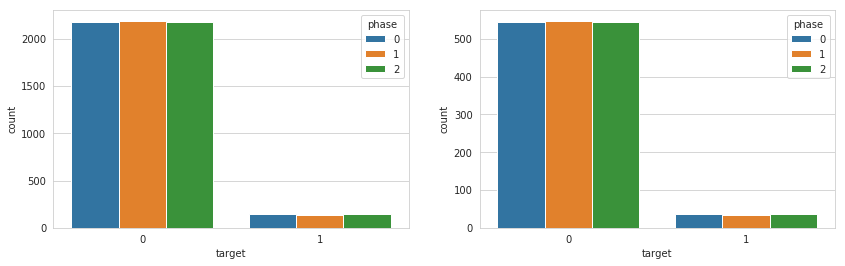

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(x="target", data=train_meta_df, hue="phase", ax=ax1)
sns.countplot(x="target", data=val_meta_df, hue="phase", ax=ax2)

In [48]:
set(train_meta_df['id_measurement']) & set(val_meta_df['id_measurement'])

set()

## 2. Process and Minimize Data

In [49]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
    lenght = len(x)
    pool = np.int32(np.ceil(lenght/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,lenght, pool)):
        if i+pool < lenght:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

In [50]:
x_train = []
y_train = []
x_val = []
y_val = []
n_part = 400
for i in tqdm(train_meta_df.signal_id):
    #idx = train_meta_df.loc[train_meta_df.signal_id==i, 'signal_id'].values.tolist()
    y_train.append(train_meta_df.loc[train_meta_df.signal_id==i, 'target'].values)
    x_train.append(abs(feature_extractor(train_set.iloc[:, i].values, n_part=n_part)))
    
for i in tqdm(val_meta_df.signal_id):
    #idx = val_meta_df.loc[val_meta_df.signal_id==i, 'signal_id'].values.tolist()
    y_val.append(val_meta_df.loc[val_meta_df.signal_id==i, 'target'].values)
    x_val.append(abs(feature_extractor(train_set.iloc[:, i].values, n_part=n_part)))

  0%|          | 1/6969 [00:00<26:12,  4.43it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in byte_scalars
  if __name__ == '__main__':
  0%|          | 0/1743 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in byte_scalars
  
100%|██████████| 1743/1743 [00:13<00:00, 139.30it/s]


In [51]:
y_train = np.array(y_train).reshape(-1,)
x_train = np.array(x_train).reshape(-1,x_train[0].shape[0])
y_val = np.array(y_val).reshape(-1,)
x_val = np.array(x_val).reshape(-1,x_val[0].shape[0])

In [52]:
x_train.shape
y_train.shape
x_val.shape
y_val.shape

(6969, 400)

(6969,)

(1743, 400)

(1743,)

## 3. Build Primitive CNN + LSTM Model

* CNN is for feature extraction and LSTM is for capturing time dependency.

In [53]:
def keras_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [55]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [56]:
n_signals = 1 #So far each instance is one signal. We will diversify them in next step
n_outputs = 1 #Binary Classification

In [57]:
#Build the model
verbose, epochs, batch_size = False, 30, 16
n_steps, n_length = 40, 10
x_train = x_train.reshape((x_train.shape[0], n_steps, n_length, n_signals))
x_train.shape
x_val = x_val.reshape((x_val.shape[0], n_steps, n_length, n_signals))
x_val.shape

(6969, 40, 10, 1)

(1743, 40, 10, 1)

In [58]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])

In [60]:
checkpointer = ModelCheckpoint(
    'best_model', 
    monitor='val_loss',
    mode='min',
    verbose=2, 
    save_best_only=True,
    save_weights_only=True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)

In [61]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=verbose, 
          callbacks=[checkpointer, early, TQDMNotebookCallback(leave_inner=True)])



Epoch 00001: val_loss improved from inf to 0.20736, saving model to best_model



Epoch 00002: val_loss did not improve from 0.20736



Epoch 00003: val_loss improved from 0.20736 to 0.15420, saving model to best_model



Epoch 00004: val_loss improved from 0.15420 to 0.14391, saving model to best_model



Epoch 00005: val_loss did not improve from 0.14391



Epoch 00006: val_loss did not improve from 0.14391



Epoch 00007: val_loss improved from 0.14391 to 0.13198, saving model to best_model



Epoch 00008: val_loss did not improve from 0.13198



Epoch 00009: val_loss did not improve from 0.13198



Epoch 00010: val_loss did not improve from 0.13198



Epoch 00011: val_loss improved from 0.13198 to 0.13007, saving model to best_model



Epoch 00012: val_loss did not improve from 0.13007



Epoch 00013: val_loss did not improve from 0.13007



Epoch 00014: val_loss did not improve from 0.13007



Epoch 00015: val_loss did not improve from 0.13007



Epoch 00016: val_loss did not improve from 0.13007



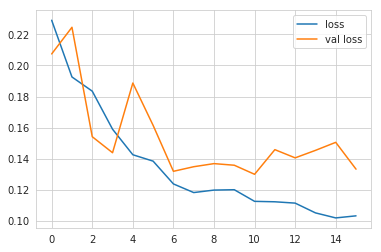

In [62]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

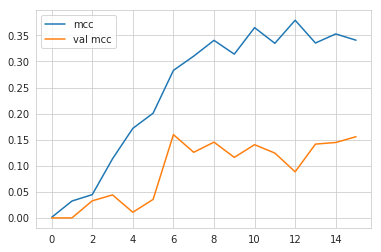

In [63]:
plt.plot(history.history['matthews_correlation'], label='mcc')
plt.plot(history.history['val_matthews_correlation'], label='val mcc')
plt.legend()

In [64]:
#model.save_weights('model1.hdf5')
model.load_weights('best_model')

In [73]:
val_preds = model.predict(x_val)
val_preds = (val_preds>0.5)*1
matthews_corrcoef(y_val, val_preds)
matthews_correlation(K.variable(y_val), K.variable(val_preds))

0.5519175287594501

<tf.Tensor 'truediv_2:0' shape=() dtype=float32>

In [66]:
%%time
test_set = pq.read_pandas('./data/test.parquet').to_pandas()

CPU times: user 2min 18s, sys: 2min 30s, total: 4min 48s
Wall time: 17.8 s


In [67]:
%%time
meta_test = pd.read_csv('./data/metadata_test.csv')

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 12.3 ms


In [68]:
x_test = []
for i in tqdm(meta_test.signal_id.values):
    idx=i-8712
    clear_output(wait=True)
    x_test.append(abs(feature_extractor(test_set.iloc[:, idx].values, n_part=400)))

100%|██████████| 20337/20337 [02:53<00:00, 117.51it/s]


In [ ]:
#del test_set; gc.collect()

In [ ]:
x_test = np.array(x_test)
X_test = x_test.reshape((x_test.shape[0], n_steps, n_length, n_signals))

In [ ]:
preds = model.predict(X_test)

In [ ]:
threshpreds = (preds>0.5)*1

In [ ]:
sub = pd.read_csv('./data/sample_submission.csv')
sub.target = threshpreds

In [ ]:
sub.to_csv('first_sub_1.csv',index=False)
#Gave me an LB score of 0.450